In [1]:
import sys; sys.path.append(2*'../'); 
import torch
from torch import nn
from torchdyn.numerics import odeint

import time

import matplotlib.pyplot as plt

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [2]:
print(torch.cuda.get_device_name(0))
print(torch.cuda.get_device_name(1))
device = torch.device("cpu")
# device = torch.device("cuda:1")

NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090


In [3]:
x_dict = {'v_t': torch.tensor([1.   , 0.95 , 0.975, 0.9  , 0.925, 0.85 , 0.875, 0.8  , 0.825,
        0.75 , 0.775, 0.7  , 0.725, 0.65 , 0.675, 0.6  , 0.625, 0.55 ,
        0.575, 0.5  , 0.525, 0.45 , 0.475, 0.4  , 0.425, 0.35 , 0.375,
        0.3  , 0.325, 0.25 , 0.275, 0.2  , 0.225, 0.15 , 0.175, 0.1  ,
        0.125, 0.05 , 0.075, 0.025]),
 'v_r': torch.tensor([0.95 , 1.   , 0.975, 0.9  , 0.925, 0.85 , 0.875, 0.8  , 0.825,
        0.75 , 0.775, 0.7  , 0.725, 0.65 , 0.675, 0.6  , 0.625, 0.55 ,
        0.575, 0.5  , 0.525, 0.45 , 0.475, 0.4  , 0.425, 0.35 , 0.375,
        0.3  , 0.325, 0.25 , 0.275, 0.2  , 0.225, 0.15 , 0.175, 0.1  ,
        0.125, 0.05 , 0.075, 0.025]),
 'sig_r': torch.tensor([0.95, 1.  , 0.9 , 0.95, 0.85, 0.9 , 0.8 , 0.85, 0.75, 0.8 , 0.7 ,
        0.75, 0.65, 0.7 , 0.6 , 0.65, 0.55, 0.6 , 0.5 , 0.55, 0.45, 0.5 ,
        0.4 , 0.45, 0.35, 0.4 , 0.3 , 0.35, 0.25, 0.3 , 0.2 , 0.25, 0.15,
        0.2 , 0.1 , 0.15, 0.05, 0.1 , 0.  , 0.05]),
 'sig_t': torch.tensor([0.95, 1.  , 0.9 , 0.95, 0.85, 0.9 , 0.8 , 0.85, 0.75, 0.8 , 0.7 ,
        0.75, 0.65, 0.7 , 0.6 , 0.65, 0.55, 0.6 , 0.5 , 0.55, 0.45, 0.5 ,
        0.4 , 0.45, 0.35, 0.4 , 0.3 , 0.35, 0.25, 0.3 , 0.2 , 0.25, 0.15,
        0.2 , 0.1 , 0.15, 0.05, 0.1 , 0.  , 0.05])}

In [4]:
dofs_dict = {'v_t': [0,
  1,
  3,
  10,
  12,
  18,
  20,
  26,
  28,
  34,
  36,
  42,
  44,
  50,
  52,
  58,
  60,
  66,
  68,
  74,
  76,
  82,
  84,
  90,
  92,
  98,
  100,
  106,
  108,
  114,
  116,
  122,
  124,
  130,
  132,
  138,
  140,
  146,
  148,
  154],
 'v_r': [2,
  4,
  5,
  11,
  13,
  19,
  21,
  27,
  29,
  35,
  37,
  43,
  45,
  51,
  53,
  59,
  61,
  67,
  69,
  75,
  77,
  83,
  85,
  91,
  93,
  99,
  101,
  107,
  109,
  115,
  117,
  123,
  125,
  131,
  133,
  139,
  141,
  147,
  149,
  155],
 'sig_r': [6,
  7,
  14,
  15,
  22,
  23,
  30,
  31,
  38,
  39,
  46,
  47,
  54,
  55,
  62,
  63,
  70,
  71,
  78,
  79,
  86,
  87,
  94,
  95,
  102,
  103,
  110,
  111,
  118,
  119,
  126,
  127,
  134,
  135,
  142,
  143,
  150,
  151,
  156,
  157],
 'sig_t': [8,
  9,
  16,
  17,
  24,
  25,
  32,
  33,
  40,
  41,
  48,
  49,
  56,
  57,
  64,
  65,
  72,
  73,
  80,
  81,
  88,
  89,
  96,
  97,
  104,
  105,
  112,
  113,
  120,
  121,
  128,
  129,
  136,
  137,
  144,
  145,
  152,
  153,
  158,
  159]}

In [5]:
class ControlledSystem(nn.Module):
    def __init__(self, A, B, u):
        super().__init__()
        self.A = A
        self.B = B
        self.u = u
        
    def forward(self, t, X):
        dX = torch.einsum('ij, ...j->...i', A, X)
        dX = dX + torch.einsum('ij, ...j->...i', B, self.u(0., X))
        return dX

### Train with `odeint`

In [6]:
import pytorch_lightning as pl
from numpy import pi


def dummy_trainloader():
    tl = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(1), torch.Tensor(1)), batch_size=1)
    return tl

trainloader = dummy_trainloader()
x0 = torch.load('x0')[None].to(device).float()
x_dim, u_dim = x0.shape[1], 2

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model.to(device)
        self.t = torch.linspace(0, 5, 500).to(device)
        self.z0 = x0
        self.model.nfe = 0 
        self.flag = 0
        self.current_time = 0
        
    def forward(self):
        _, zT = odeint(self.model, self.z0, self.t, 
                    solver='rk4')
        return zT
    
    def training_step(self, batch, batch_idx):      
        if not self.flag:
            self.current_time = time.time()
            self.flag = 1.        
        fw_time = time.time() - self.current_time
        self.current_time = time.time()
        
        # forward pass
        self.model.nfe = 0

        zT = self()
        fw_nfe = self.model.nfe


        control_loss = torch.norm(zT[:,0,dofs_dict['sig_t']], p=2, dim=-1).mean()
        control_loss = control_loss + torch.norm(zT[:,0,dofs_dict['sig_r']], p=2, dim=-1).mean()
        reg_loss = 1e-3*self.model.u(0., zT).abs().mean()
        loss = control_loss + reg_loss
        
        # with torch.no_grad():
        #     self.logger.experiment.log(
        #         {
        #             'control_loss': torch.clone(control_loss).cpu().detach(),
        #             'reg_loss': torch.clone(reg_loss).cpu().detach(),
        #             'train loss': torch.clone(loss).cpu().detach(),
        #             'fw_nfe': fw_nfe,
        #             'fw_time': fw_time
        #         }
        #     )
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader


In [7]:
from src.controllers import BoxConstrainedController
import time

In [8]:
A = torch.load('A_sys').to(device).float()
B = torch.load('B_sys').to(device).float()

import wandb
from pytorch_lightning.loggers import WandbLogger

# hdim = 16
# u = nn.Sequential(
#     nn.Linear(x_dim, hdim),
#     nn.Softplus(),
#     nn.Linear(hdim, hdim),
#     nn.Softplus(),
#     nnt.Linear(hdim, hdim),
#     nn.Tanh(),
#     nn.Linear(hdim, u_dim)).to(device)

# for p in u[-1].parameters(): torch.nn.init.zeros_(p)

u = BoxConstrainedController(x_dim, u_dim, h_dim=64).to(device)

f = ControlledSystem(A, B, u).to(device)
t = torch.linspace(0, 5, 500+1).to(device)


learn = Learner(f).to(device)
# wandb.init(project='rk4-pde')
# logger = WandbLogger(project='rk4-pde', log_model=False)

trainer = pl.Trainer(max_epochs=100, gradient_clip_val=.3) #, logger=logger
trainer.fit(learn)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/home/botu/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
/home/botu/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type             | Params
-------------------------------------------
0 | model | ControlledSystem | 14 K  
/home/botu/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataL

Saving latest checkpoint..


1

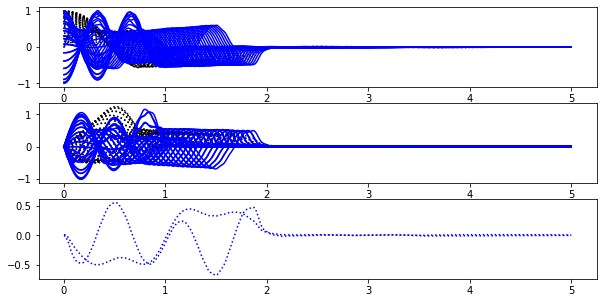

In [9]:
t = torch.linspace(0, 5, 500+1)
_, xT = odeint(f.to(device), x0.to(device), t, solver='rk4')
xT = xT.detach().cpu()
uT = f.u(0, xT.to(device))

v_t = xT[:,0,dofs_dict['v_t']]
v_r = xT[:,0,dofs_dict['v_r']]
sig_t = xT[:,0,dofs_dict['sig_t']]
sig_r = xT[:,0,dofs_dict['sig_r']]

fig, axs = plt.subplots(3, 1, figsize=(10, 5))
axs[0].plot(t.cpu(), v_t, ':k');
axs[0].plot(t.cpu(), v_r, 'b');
axs[1].plot(t.cpu(), sig_t, ':k');
axs[1].plot(t.cpu(), sig_r, 'b');
axs[2].plot(t.cpu(), uT[:,0,:].detach().cpu(), ':b');

(-0.1, 0.1)

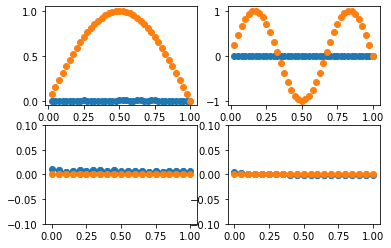

In [10]:
v_t = xT[:,0,dofs_dict['v_t']].cpu()
v_r = xT[:,0,dofs_dict['v_r']].cpu()
sig_t = xT[:,0,dofs_dict['sig_t']].cpu()
sig_r = xT[:,0,dofs_dict['sig_r']].cpu()

x_v_t = x_dict['v_t'].cpu()
x_v_r = x_dict['v_r'].cpu()
x_sig_t = x_dict['sig_t'].cpu()
x_sig_r = x_dict['sig_r'].cpu()


fig, axs = plt.subplots(2, 2)
axs[0,0].scatter(x_v_t, v_t[-1])
axs[0,1].scatter(x_v_r, v_r[-1])
axs[1,0].scatter(x_sig_t, sig_t[-1])
axs[1,1].scatter(x_sig_r, sig_r[-1])
axs[0,0].scatter(x_v_t, v_t[0])
axs[0,1].scatter(x_v_r, v_r[0])
axs[1,0].scatter(x_sig_t, sig_t[0])
axs[1,1].scatter(x_sig_r, sig_r[0])

axs[1,0].set_ylim([-.1, .1])
axs[1,1].set_ylim([-.1, .1])

## Calculate stiffness coefficient

Considering the following system:

$$y'(x) = Ay(x), ~ A \in \mathbb{R}^{n \times n}$$

which is, our Timoshenko beam without the controller

If $Re(\lambda_i) < 0 ~ \forall i\in [1, n]$, or the real part of the eigenvalues is always negative, then the stiffness coefficient can be calculated as:

$$q = \frac{ max|Re(\lambda_i)| ,~ i = 1, \dots, n}{ min | Re(\lambda_i)|, ~ i=1, \dots, n }$$


In [33]:
# here real part is not always negative, so ciaone

eigenvalues = torch.linalg.eigvals(A)
eig_real =  eigenvalues.real
eig_real_abs = torch.abs(eig_real)
q = torch.max(eig_real_abs) / torch.min(eig_real_abs)
print(eig_real)
print(torch.max(eig_real_abs))
print(torch.min(eig_real_abs))
print(q)    

tensor([-4.5411e-06, -4.5411e-06, -2.4736e-06, -2.4736e-06, -7.6331e-06,
        -7.6331e-06, -6.1393e-06, -6.1393e-06,  4.1053e-06,  4.1053e-06,
         1.9073e-06,  1.9073e-06,  2.5742e-06,  2.5742e-06, -1.6987e-06,
        -1.6987e-06, -5.9605e-08, -5.9605e-08, -2.6822e-07, -2.6822e-07,
        -7.1526e-06, -7.1526e-06, -1.9073e-06, -1.9073e-06, -7.6294e-06,
        -7.6294e-06, -7.6294e-06, -7.6294e-06,  5.2154e-08,  5.2154e-08,
         7.4506e-09,  7.4506e-09,  2.0117e-06,  2.0117e-06, -3.2187e-06,
        -3.2187e-06, -1.9632e-06, -1.9632e-06, -1.4305e-06, -1.4305e-06,
        -7.7859e-07, -7.7859e-07,  0.0000e+00,  0.0000e+00,  5.4948e-06,
         5.4948e-06,  3.7849e-06,  3.7849e-06,  2.8610e-06,  2.8610e-06,
         8.1062e-06,  8.1062e-06, -8.9407e-07, -8.9407e-07,  1.4305e-06,
         1.4305e-06,  3.8072e-06,  3.8072e-06, -8.6576e-06, -8.6576e-06,
        -2.6822e-07, -2.6822e-07,  3.0734e-07,  3.0734e-07, -3.4422e-06,
        -3.4422e-06, -3.2317e-06, -3.2317e-06,  4.2